<a href="https://colab.research.google.com/github/PengWenjin/stiffGWpy/blob/main/testrun.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os, sys, time, yaml
import multiprocessing as mp
from pathlib import Path
from importlib import reload
import numpy as np
import pandas as pd
import math
from scipy import interpolate, integrate, special
from scipy.integrate import odeint, solve_ivp
#from astropy.cosmology import Planck18 as cosmo
#from astropy import constants as const
#import astropy.units as u
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
#from mpl_toolkits.axes_grid1.inset_locator import mark_inset
#from mpl_toolkits.axes_grid1.inset_locator import inset_axes
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
sys.path.append("/content/drive/MyDrive/stiffGWpy-main/")
%cd /content/drive/MyDrive/stiffGWpy-main/

Mounted at /content/drive
/content/drive/MyDrive/stiffGWpy-main


In [ ]:
# Import stiffGWpy related modules

import global_param; reload(global_param)
from global_param import *
import functions; reload(functions)
from functions import int_FD, solve_SGWB

import LCDM_stiff_Neff; reload(LCDM_stiff_Neff)
from LCDM_stiff_Neff import LCDM_SN as sn

import stiff_SGWB; reload(stiff_SGWB)
from stiff_SGWB import LCDM_SG as sg

In [ ]:
# 1. A single model can be instantiated by a yaml file

model1 = sg('base_param.yml')

model1.cosmo_param, model1.derived_param['nt'], model1.derived_param['N_re'], model1.SGWB_converge, model1.DN_eff_orig,

({'Omega_bh2': 0.02242,
  'Omega_ch2': 0.11933,
  'H0': 67.66,
  'DN_eff': 0,
  'A_s': 2.105e-09,
  'r': 0.036,
  'n_t': 0,
  'cr': 0,
  'T_re': 1000.0,
  'DN_re': 0,
  'kappa10': 1.0},
 0,
 array(37.07894199),
 False,
 None)

In [ ]:
# 2. A single model can be instantiated by explicitly inputing parameter values.
#    For any unspecified parameter at initialization, its default value is taken.

model2 = sg(r = 1e-2,
            T_re = 1e11,
            )

print(model2.cosmo_param)
model2.derived_param, model2.SGWB_converge

{'Omega_bh2': 0.0223828, 'Omega_ch2': 0.1201075, 'H0': 67.32117, 'DN_eff': 0.0, 'A_s': 2.100549e-09, 'r': 0.01, 'n_t': 0.0, 'cr': 0, 'T_re': 100000000000.0, 'DN_re': 0, 'kappa10': 0.0}


({'h': 0.6732117,
  'H_0': 2.181730534771633e-18,
  'Omega_mh2': 0.14249030000000001,
  'Omega_sh2': 0.0,
  'A_t': 2.1005489999999998e-11,
  'nt': 0.0,
  'kappa_s': 0.0,
  'N_re': 55.50152651224954,
  'rho_re': 0.658435092,
  'N_inf': 55.50152651224954},
 False)

In [ ]:
t1 = time.time()
model1.SGWB_iter()
t2= time.time()

# If converged, the SGWB spectrum is stored by the 'self.f' (log_{10} f/Hz)
# and the 'self.log10OmegaGW' (Omega_{GW}) arrays.

print(t2-t1, model1.SGWB_converge, model1.cosmo_param['DN_eff'], model1.DN_eff_orig, )
model1.derived_param['kappa_s'], model1.kappa_r, model1.f[0], len(model1.f)

39.4677631855011 True 0.23770921056126834 0


(0.05383199551801364, 0.2055974200855285, 0.5417197683926459, 96)

In [ ]:
t1 = time.time()
model2.SGWB_iter()
t2 = time.time()

print(model2.derived_param['kappa_s'], model2.kappa_r)
print(t2-t1, model2.hubble[-1], model2.cosmo_param['DN_re'],
      model2.derived_param['N_inf']==model2.derived_param['N_re'] + model2.cosmo_param['DN_re'])
model2.DN_gw[-1], model2.cosmo_param['DN_eff'], model2.SGWB_converge, len(model2.f)

0.0 1.869484425186645e-09
25.223198413848877 -17.66119889008519 0 True


(2.161474918716568e-09, 2.161474918716568e-09, True, 86)

In [ ]:
# 3. A single model can be instantiated by passing a dictionary of parameters

model3 = sg(model1.cosmo_param)

# After initialization, the model parameters can be modified again
# via the 'cosmo_param' dictionary.

model3.cosmo_param['DN_eff'] = 0
model3.cosmo_param['kappa10'] = 1e2
model3.cosmo_param['T_re'] = 1e1
model3.cosmo_param['H0'] = 67.5
model3.cosmo_param['cr'] = 1


print(model1.cosmo_param)
print(model3.cosmo_param)
print(model1.derived_param['nt'], model3.derived_param['nt'],)
model1.derived_param['N_re'], model1.derived_param['N_inf'], model3.derived_param['N_re'], model3.derived_param['N_inf'], model3.SGWB_converge

{'Omega_bh2': 0.02242, 'Omega_ch2': 0.11933, 'H0': 67.66, 'DN_eff': 0.23770921056126834, 'A_s': 2.105e-09, 'r': 0.036, 'n_t': 0, 'cr': 0, 'T_re': 1000.0, 'DN_re': 0, 'kappa10': 1.0}
{'Omega_bh2': 0.02242, 'Omega_ch2': 0.11933, 'H0': 67.5, 'DN_eff': 0, 'A_s': 2.105e-09, 'r': 0.036, 'n_t': 0, 'cr': 1, 'T_re': 10.0, 'DN_re': 0, 'kappa10': 100.0}
0 -0.0045


(array(37.07894199),
 37.07894199496586,
 array(32.39051243),
 71.55323868932291,
 False)

In [ ]:
t1 = time.time()
model3.SGWB_iter()
t2 = time.time()

print(model3.derived_param['kappa_s'], model3.kappa_r)
t2-t1, model3.hubble[-1], model3.DN_gw[-1], model3.cosmo_param['DN_eff'], model3.SGWB_converge, model3.f[0], len(model3.f)

5.383199551801363 0.0013588198214598722


(167.91643571853638,
 -17.66004677239111,
 0.0015710507793330294,
 0.0015710507793330294,
 True,
 5.980209374984388,
 239)

In [ ]:
# Any model instance can be reused by the 'reset' method.

model3.reset()
print(model3.SGWB_converge, model3.DN_eff_orig, model3.cosmo_param['DN_eff'])

model3.cosmo_param['r'] = 1e-22
model3.cosmo_param['n_t'] = 4
model3.cosmo_param['cr'] = 0
model3.cosmo_param['T_re'] = 1e-2
model3.cosmo_param['DN_re'] = 30
model3.cosmo_param['kappa10'] = 0e-10
print(model3.derived_param)


t1 = time.time()
model3.SGWB_iter()
t2 = time.time()

t2-t1, model3.hubble[-1], model3.DN_gw[-1], model3.cosmo_param['DN_eff'], model3.SGWB_converge, model3.f[0], len(model3.f), model3.kappa_r

False None 0
{'h': 0.675, 'H_0': 2.1875260203749465e-18, 'Omega_mh2': 0.14175000000000001, 'Omega_sh2': 0.0, 'A_t': 2.105e-31, 'nt': 4, 'kappa_s': 0.0, 'N_re': array(24.8098282), 'rho_re': array(1.40552573), 'N_inf': 54.809828196088255}


(58.765196084976196,
 -17.66004677239111,
 0.00017869223508267592,
 0.00017869223508267592,
 True,
 -8.442552731359228,
 198,
 0.00015455296172819412)

In [ ]:
# Consistency check

model1.DN_eff_orig, model2.DN_eff_orig, model3.DN_eff_orig, model3.DN_eff_orig + model3.DN_gw[-1] == model3.cosmo_param['DN_eff']

(0, 0.0, 0, True)

In [ ]:
# Now let us plot a representative example

model4 = sg(r=3.9585109e-05, n_t=1.0116972, cr=0, T_re=0.17453859, DN_re=39.366618, kappa10=110.42477,)

t1 = time.time()
model4.SGWB_iter()
t2 = time.time()

print(model4.derived_param['kappa_s'], model4.kappa_r)
print(t2-t1, len(model4.f), model4.f[0], model4.hubble[-1], model4.cosmo_param['DN_re'])
model4.DN_gw[-1], model4.cosmo_param['DN_eff'], model4.SGWB_converge

5.944385723717686 2.139693196299085
239.43898248672485 227 -3.1828363368250905 -17.66119889008519 39.366618


(2.473886979340424, 2.473886979340424, True)

Text(0, 0.5, '$1+w$')

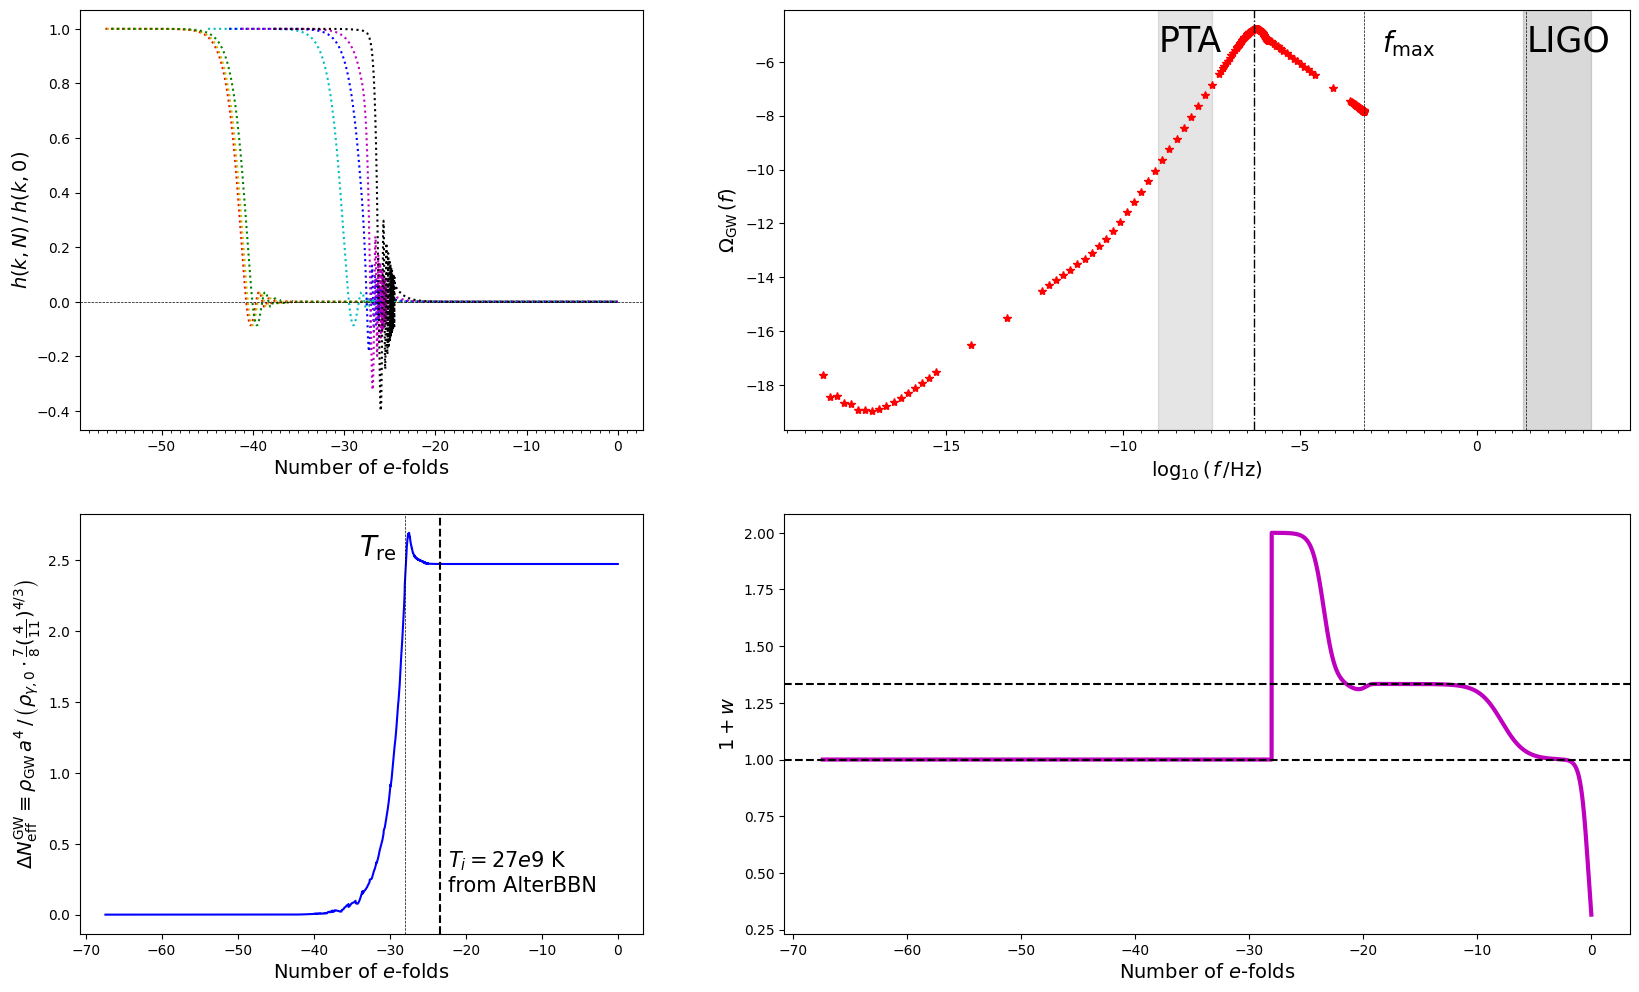

In [ ]:
colors = plt.get_cmap('rainbow')(np.arange(0,1.1,.1))
lc = plt.get_cmap('Paired')
shade = plt.get_cmap('Set3')

model = model4

fig1, ((ax1, ax2), (ax3, ax4),) = plt.subplots(2, 2,
                                              gridspec_kw={
                                                  'width_ratios': [2, 3],
                                                  'height_ratios': [1, 1]},
                                              figsize=(20,12))
Ntot = model.Nv[-1]
#ind = len(model.f[model.f>model.f[0]-3])
ind = len(model.f[model.Tensor_power(model.f)>=1])
cond1 = model.N_hc[ind]>=model.Nv[model.find_index_hc(model.f[ind]-3)]
#cond2 = model.N_hc[ind+20]>=model.Nv[model.find_index_hc(model.f[ind+20]-3)]

ax1.plot(model.N_hc[0]-Ntot, model.Th[0], 'r:',
         model.N_hc[30]-Ntot, model.Th[30], 'y:',
         model.N_hc[60]-Ntot, model.Th[60], 'g:',
         model.N_hc[90]-Ntot, model.Th[90], 'c:',
         model.N_hc[120]-Ntot, model.Th[120], 'b:',
         model.N_hc[150]-Ntot, model.Th[150], 'm:',
         model.N_hc[180]-Ntot, model.Th[180], 'k:',
        )
ax1.axhline(0, ls='--', c='k', lw=.5)
#ax1.axvline(model.N[model.find_index_hc(model.f[ind]-3)], ls='--', c='k', lw=.5)
#ax1.set_xlim(26.5,28)
#ax1.set_ylim(500,2e3)
#ax1.text(model.Nv[model.find_index_hc(model.f[80]-3)]+1,.9, '$kc\,/\,aH \geq 10^3$', fontsize=15)
ax1.set_xlabel('Number of $e$-folds', fontsize=14)
ax1.set_ylabel('$h(k,N)\,/\,h(k,0)$', fontsize=14)
ax1.xaxis.set_minor_locator(MultipleLocator(1))

ax2.plot(#model.f[model.f<=model.f[0]-3], model.log10OmegaGW[model.f<=model.f[0]-3], 'r*',
         model.f, model.log10OmegaGW, 'r*',
         #model.f, [model.Ogw[i][-1]-model.Oj[i][-1] for i in range(len(model.f))], 'r*',
         #[model.f[i] for i in range(len(model.f)) if (Nslice:=14.8) in model.N_hc[i][:]], \
         #[model.Ogw[i][model.N_hc[i][:]==Nslice][0]-model.Oj[i][model.N_hc[i][:]==Nslice][0] \
         #for i in range(len(model.f)) if Nslice in model.N_hc[i][:]], 'r*',
         #model.f, np.log10(model.Tensor_power(model.f)),
         #model.f_grid, model.log10OmegaGW_grid, 'k*',
        )
#ax2.axhline(0, ls='--', c='k', lw=.5)
ax2.axvspan(np.log10(20), np.log10(1726), alpha=0.15, color='black')
ax2.axvline(np.log10(25), ls='--', c='k', lw=.5)
ax2.axvspan(-9, np.log10(1/yr), alpha=0.1, color='black')
ax2.axvline(model.f_re, ls='-.', c='k', lw=1)
ax2.axvline(model.f[0], ls='--', c='k', lw=.5)
ax2.text(model.f[0]+.5,.9, '$f_\mathrm{max}$', transform=ax2.get_xaxis_transform(), fontsize=20)
ax2.text(np.log10(25),.9, 'LIGO', transform=ax2.get_xaxis_transform(), fontsize=25)
ax2.text(-9,.9, 'PTA', transform=ax2.get_xaxis_transform(), fontsize=25)
#ax2.set_xlim(-6.7,-6.3)
#ax2.set_ylim(-10,-5)
ax2.set_xlabel('$\log_{10}(\,f\,/\mathrm{Hz})$', fontsize=14)
ax2.set_ylabel('$\Omega_\mathrm{GW}\,(f)$', fontsize=14)
#ax2.set_ylabel('$P_\mathrm{T}\,(f)$', fontsize=14)
ax2.xaxis.set_minor_locator(MultipleLocator(.5))


ax3.plot(model.N, model.DN_gw, 'b-',
        )
#ax3.axvline(model.N[len(model.g2[model.g2<=0])-1], ls='--', c='k')
ax3.axvline(-model.derived_param['N_re'], ls='--', c='k', lw=.5)
ax3.text(-model.derived_param['N_re']-6,.9, '$T_\mathrm{re}$', transform=ax3.get_xaxis_transform(), fontsize=20)
ax3.axvline(-N_i, ls='--', c='k')
ax3.text(-N_i+1,.1, '$T_i=27e9~\mathrm{K}$\nfrom AlterBBN', transform=ax3.get_xaxis_transform(), fontsize=15)
ax3.set_xlabel('Number of $e$-folds', fontsize=14)
ax3.set_ylabel('$\Delta N_\mathrm{eff}^\mathrm{GW}\equiv$' +
               '$\\rho_\mathrm{GW}\,a^4\,/\,\\left(\\rho_{\gamma,0}\cdot\\frac{7}{8}(\\frac{4}{11})^{4/3}\\right)$', fontsize=14)

ax4.plot(model.N, model.sigma, 'm-', lw=3)
ax4.axhline(4/3, ls='--', c='k')
ax4.axhline(1, ls='--', c='k')
ax4.set_xlabel('Number of $e$-folds', fontsize=14)
ax4.set_ylabel('$1+w$', fontsize=14)

In [ ]:
freqs_N15 = np.load('cobaya/likelihoods/PTA/NANOGrav15yr/freqs.npy')
T_N15 = 1/freqs_N15[0]
freqs_N15 = np.log10(freqs_N15[:14])

NG15 = np.loadtxt('cobaya/likelihoods/PTA/NANOGrav15yr/sample.txt')
NG15_mock = np.loadtxt('cobaya/likelihoods/PTA/NANOGrav15yr/sample_mock.txt')

T_N15/yr, freqs_N15, NG15.shape

(16.029777268872294,
 array([-8.70403146, -8.40300146, -8.2269102 , -8.10197146, -8.00506145,
        -7.9258802 , -7.85893342, -7.80094147, -7.74978895, -7.70403146,
        -7.66263877, -7.62485021, -7.5900881 , -7.55790342]),
 (30000, 14))

In [ ]:
hc_NG15 = NG15 + np.log10(T_N15*12*np.pi**2)/2 + 1.5*freqs_N15
Ogw_NG15 = 2*NG15 + np.log10(T_N15*8) + 4*np.log10(np.pi) + 5*freqs_N15 - 2*np.log10(cosmo.H0.to(u.Hz).value)

hcmock_NG15 = NG15_mock + np.log10(T_N15*12*np.pi**2)/2 + 1.5*freqs_N15
Ogwmock_NG15 = 2*NG15_mock + np.log10(T_N15*8) + 4*np.log10(np.pi) + 5*freqs_N15 - 2*np.log10(cosmo.H0.to(u.Hz).value)

In [ ]:
EPTA_freqsnew = np.loadtxt('cobaya/likelihoods/PTA/EPTAdr2/freqs_dr2new.txt')
T_EPTA = 1/EPTA_freqsnew[0]
EPTA_freqsnew = np.log10(EPTA_freqsnew[:9])

EPTAnew = np.loadtxt('cobaya/likelihoods/PTA/EPTAdr2/EPTA_dr2new.dat')
EPTAnew_mock = np.loadtxt('cobaya/likelihoods/PTA/EPTAdr2/EPTA_dr2new_mock.dat')

EPTA_freqsnew, T_EPTA/yr, EPTAnew.shape

(array([-8.51338223, -8.21235223, -8.03626097, -7.91132224, -7.81441222,
        -7.73523098, -7.66828419, -7.61029224, -7.55913972]),
 10.334233275027252,
 (29990, 9))

In [ ]:
hc_EPTA = EPTAnew + np.log10(T_EPTA*12*np.pi**2)/2 + 1.5*EPTA_freqsnew
Ogw_EPTA = 2*EPTAnew + np.log10(T_EPTA*8) + 4*np.log10(np.pi) + 5*EPTA_freqsnew - 2*np.log10(cosmo.H0.to(u.Hz).value)

hcmock_EPTA = EPTAnew_mock + np.log10(T_EPTA*12*np.pi**2)/2 + 1.5*EPTA_freqsnew
Ogwmock_EPTA = 2*EPTAnew_mock + np.log10(T_EPTA*8) + 4*np.log10(np.pi) + 5*EPTA_freqsnew - 2*np.log10(cosmo.H0.to(u.Hz).value)